In [1]:
### IMPORT LIBRARIES

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize']=(20,20) # graph size

# pandas and statsmodels
import pandas
from statsmodels.stats.weightstats import DescrStatsW

# analog data assimilation
from AnDA_codes.AnDA_generate_data import AnDA_generate_data
from AnDA_codes.AnDA_analog_forecasting import AnDA_analog_forecasting
from AnDA_codes.AnDA_model_forecasting import AnDA_model_forecasting
from AnDA_codes.AnDA_data_assimilation import AnDA_data_assimilation
from AnDA_codes.AnDA_stat_functions import AnDA_RMSE

Populating the interactive namespace from numpy and matplotlib


In [2]:
### DATA
data_dir = '/home/arthur/scripts/TCsLifeMonitFromObs/AnDA/AnDA_data/IBTrACS_V2/'

In [3]:
### IMPORTANT PARAMETERS

# name and date of the tropical cyclone
# TC_name = str("'KATE'" + '_' + "'2003269N12322'")
TC_name = str("'SAM'" + '_' + "'2021262N10349'")

# number of analogs
nb_analogs = 100

# variance of the observations
sigma2_obs = 0.05

# index of the first unavailable observation
index_NaN = -1 # 60

In [4]:
# IBTrACS_tmp

In [5]:
### GENERATE THE CATALOG, THE TRUE STATE, AND THE OBSERVATIONS

import os
files = os.listdir(data_dir)
class catalog:
    IBTrACS_tmp = array(pandas.read_csv(data_dir + files[0], usecols = ['Vmax', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']))
    analogs = IBTrACS_tmp[0:-1,:]
    successors = IBTrACS_tmp[1:,:]
for i in arange(1, len(files)):
    if files[i] != TC_name:
        IBTrACS_tmp = array(pandas.read_csv(data_dir + files[i], usecols = ['Vmax', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']))
        catalog.analogs = concatenate([catalog.analogs, IBTrACS_tmp[0:-1,:]])
        catalog.successors = concatenate([catalog.successors, IBTrACS_tmp[1:,:]])
    else:
        class xt:
            time = []
            values = []
        IBTrACS_tmp = array(pandas.read_csv(data_dir + files[i], usecols = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']))
        xt.time = range(shape(IBTrACS_tmp)[0])
        xt.values = IBTrACS_tmp
        class yo:
            time = []
            values = []
        IBTrACS_tmp = array(pandas.read_csv(data_dir + files[i], usecols = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']))
        yo.time = range(shape(IBTrACS_tmp)[0])
        yo.values = IBTrACS_tmp
        yo.values[index_NaN:,] = NaN
        #yo.values[:,1] = NaN # remove observations of Rmax

# center and reduce the 6 columns
mean_IBTrACS = mean(catalog.analogs, axis=0)
std_IBTrACS = std(catalog.analogs, axis=0)
for j in range(shape(catalog.analogs)[1]):
    catalog.analogs[:,j] = (catalog.analogs[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    catalog.successors[:,j] = (catalog.successors[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    xt.values[:,j] = (xt.values[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    yo.values[:,j] = (yo.values[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]

In [6]:
### ANALOG DATA ASSIMILATION (dynamical model given by the catalog)

n = shape(catalog.analogs)[1]

# parameters of the analog forecasting method
class AF:
    k = nb_analogs # number of analogs
    neighborhood = np.ones(n) # global analogs
    catalog = catalog # catalog with analogs and successors
    regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')

# parameters of the filtering method
class DA:
    method = 'AnEnKS' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N = 1000 # number of members (AnEnKF/AnEnKS) or particles (AnPF)
    xb = xt.values[0,:]; B = np.eye(n)
    H = np.eye(n)
    R = sigma2_obs*np.eye(n)
    @staticmethod
    def m(x):
        return AnDA_analog_forecasting(x, AF)
    
# run the analog data assimilation
x_hat_analog = AnDA_data_assimilation(yo, DA)

100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 283.02it/s]


In [7]:
# compute weighted quantiles
x_hat_analog_quantiles = zeros([shape(x_hat_analog.part)[0], 7, n])
for t in range(shape(x_hat_analog.part)[0]):
    for j in range(n):
        wq = DescrStatsW(data=x_hat_analog.part[t,:,j], weights=x_hat_analog.weights[t,:])
        x_hat_analog_quantiles[t,:,j] = wq.quantile(probs=np.array([0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]), return_pandas=False)

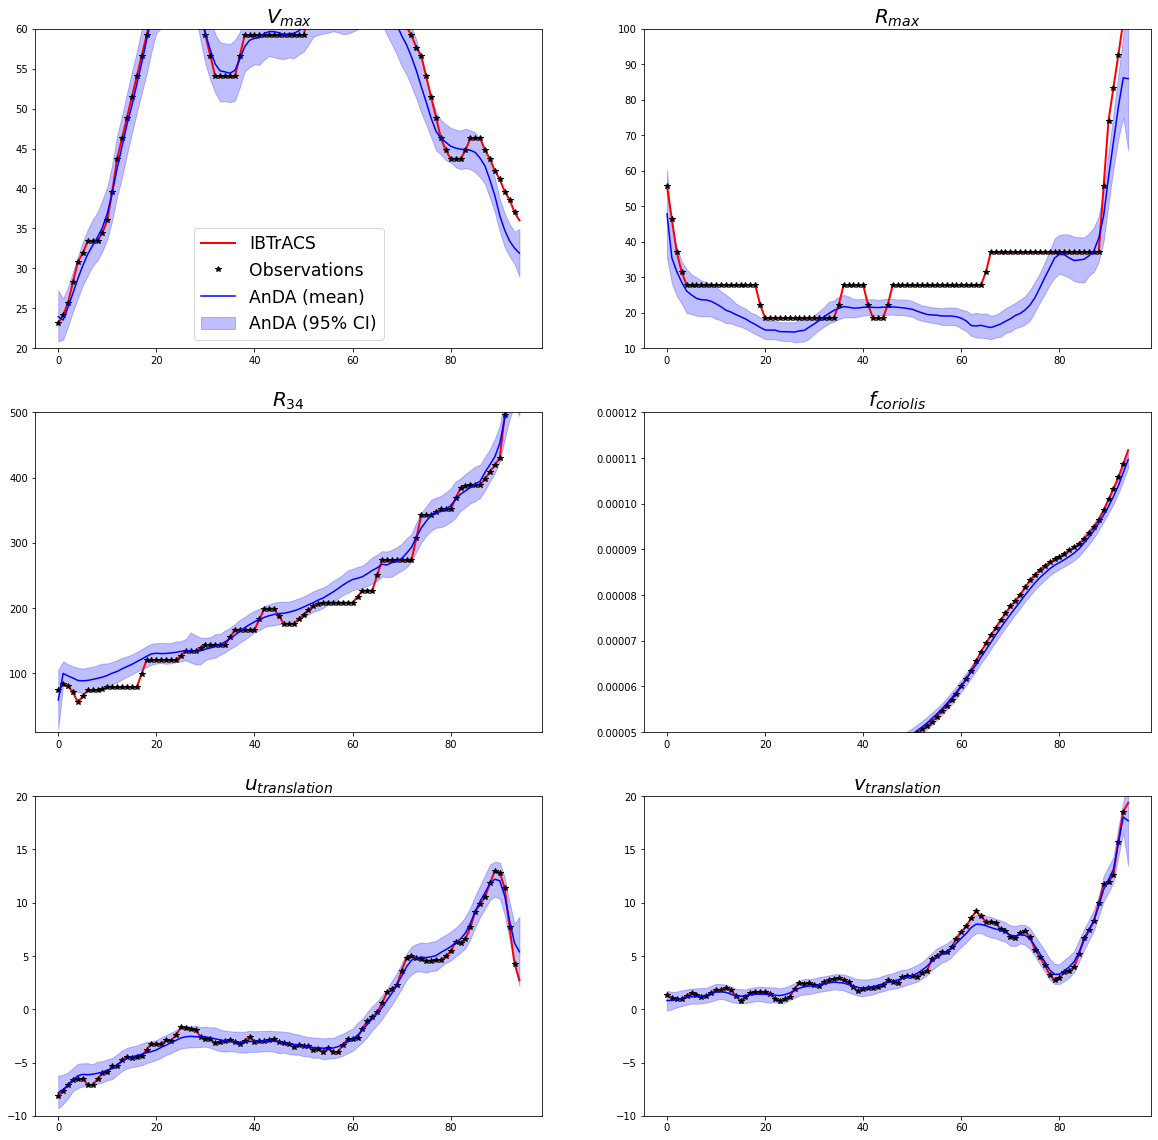

In [8]:
# plot Vmax, Rmax, R34, f, U, V
tab_title = ['$V_{max}$', '$R_{max}$', '$R_{34}$', '$f_{coriolis}$', '$u_{translation}$', '$v_{translation}$']
y_lims = [[20, 60], [10, 100], [10, 500], [0.00005, 0.00012], [-10, 20], [-10, 20]]
for j in range(n):
    subplot(3,2,j+1)
    plot(xt.time, xt.values[:,j] * std_IBTrACS[j] + mean_IBTrACS[j], '-r', linewidth=2)
    plot(yo.time, yo.values[:,j] * std_IBTrACS[j] + mean_IBTrACS[j], '*k')
    plot(yo.time, x_hat_analog_quantiles[:,3,j] * std_IBTrACS[j] + mean_IBTrACS[j], '-b')
    fill_between(x_hat_analog.time, x_hat_analog_quantiles[:,0,j] * std_IBTrACS[j] + mean_IBTrACS[j], x_hat_analog_quantiles[:,6,j] * std_IBTrACS[j] + mean_IBTrACS[j], alpha=0.25, color='b')
    ylim(y_lims[j])
    title(tab_title[j], size=20)
    if j==0:
        legend(['IBTrACS', 'Observations', 'AnDA (mean)', 'AnDA (95% CI)'], loc=0, fontsize='xx-large')

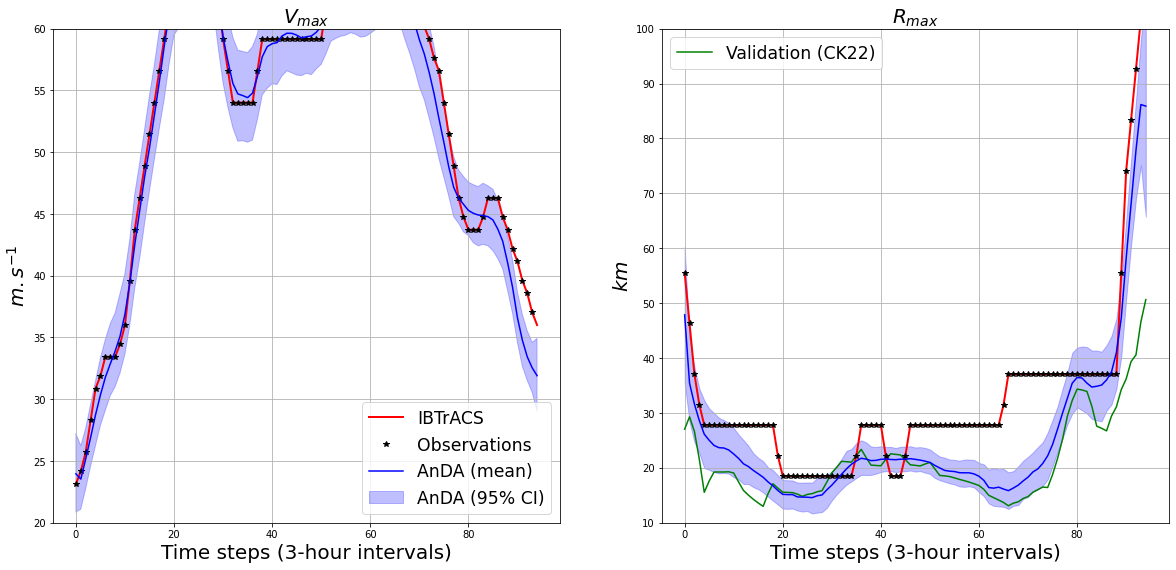

In [9]:
# focus on Vmax and Rmax (DECODages presentation)

tab_title = ['$V_{max}$', '$R_{max}$']
tab_ylabel = ['$m.s^{-1}$', '$km$']
y_lims = [[20, 60], [10, 100]]

for i in arange(1, len(files)):
    if files[i] == TC_name:
        IBTrACS_kate = array(pandas.read_csv(data_dir + files[i], usecols = ['Vmax', 'Rmax_IBT', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']))

# plot
for j in range(2):
    subplot(2,2,j+1)
    if j==1:
        plot(xt.time, IBTrACS_kate[:,2], '-g')
    plot(xt.time, xt.values[:,j] * std_IBTrACS[j] + mean_IBTrACS[j], '-r', linewidth=2)
    plot(yo.time, yo.values[:,j] * std_IBTrACS[j] + mean_IBTrACS[j], '*k')
    plot(yo.time, x_hat_analog_quantiles[:,3,j] * std_IBTrACS[j] + mean_IBTrACS[j], '-b')
    fill_between(x_hat_analog.time, x_hat_analog_quantiles[:,0,j] * std_IBTrACS[j] + mean_IBTrACS[j], x_hat_analog_quantiles[:,6,j] * std_IBTrACS[j] + mean_IBTrACS[j], alpha=0.25, color='b')
    ylim(y_lims[j])
    title(tab_title[j], size=20)
    xlabel('Time steps (3-hour intervals)', size=20)
    ylabel(tab_ylabel[j], size=20)
    grid()
    if j==0:
        legend(['IBTrACS', 'Observations', 'AnDA (mean)', 'AnDA (95% CI)'], loc=0, fontsize='xx-large')
    if j==1:
        legend(['Validation (CK22)'], loc=0, fontsize='xx-large')